In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
x5 = np.arange(-5, 5, 0.25)
x5

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
y5 = f(x5)
y5

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

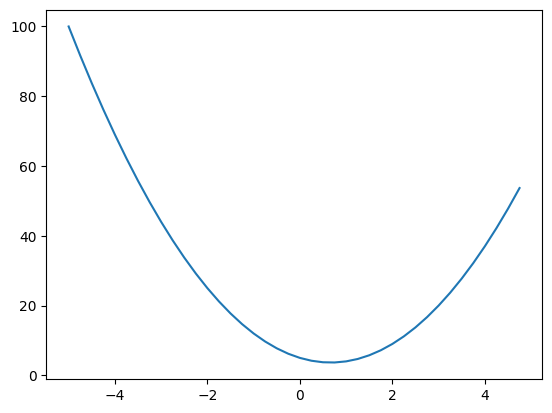

In [6]:
plt.plot(x5, y5)

In [7]:
h = 0.0000001
x = 3.0
f(x), f(x+h)

(20.0, 20.00000140000003)

In [8]:
(f(x+h) - f(x)) / h

14.000000305713911

In [9]:
h = 0.000001
x = 2/3
f(x), f(x+h)

(3.666666666666667, 3.6666666666696663)

In [10]:
(f(x+h) - f(x)) / h

2.999378523327323e-06

In [11]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [12]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h) # d'nin a'ya göre türevi b olduğu için yani -3 sonuç da bu şekilde geldi, yani a'daki her artış b çarpanı kadar etki ediyor.

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [13]:
a = 2.0
d3 = a*b + c
b += h
d4 = a*b + c

print("d1", d3)
print("d2", d4)
print("slope", (d4 - d3) / h) # d'nin b'ye göre türevi a olduğu için a değeri kadar yani 2 birimlik bir değişim gözlenir.

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [14]:
b = -3.0
d5 = a*b + c
c += h
d6 = a*b + c

print("d1", d5)
print("d2", d6)
print("slope", (d6 - d5) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [203]:
class Value:

  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # for leaf node nothing to do but we will change for others
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f"**{other}")

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self -> 2 * a execute an error
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - (t ** 2)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e + c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"
d, L

(Value(data=4.0), Value(data=-8.0))

In [182]:
a = Value(2.0)
b = Value(4.0)
a.exp(), a / b, a - b

(Value(data=7.38905609893065), Value(data=0.5), Value(data=-2.0))

In [31]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [32]:
d._op

'+'

In [36]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ("record") node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

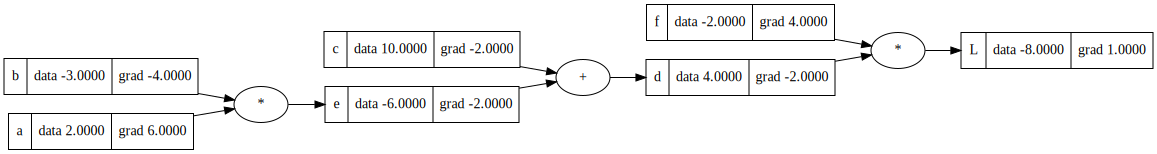

In [48]:
draw_dot(L)

In [49]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [46]:
def lol():

  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label="e"
  d = e + c; d.label="d"
  f = Value(-2.0, label="f")
  L = d*f; L.label="L"
  L1 = L.data

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0 + h, label="c")
  e = a*b; e.label="e"
  d = e + c; d.label="d"
  f = Value(-2.0, label="f")
  L = d*f; L.label="L"
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.9999999999953388


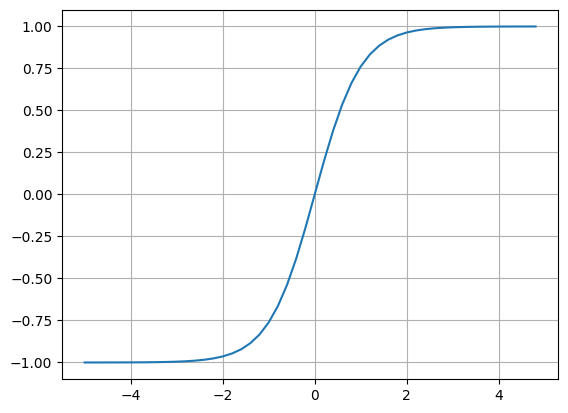

In [50]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [135]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"
o.backward()

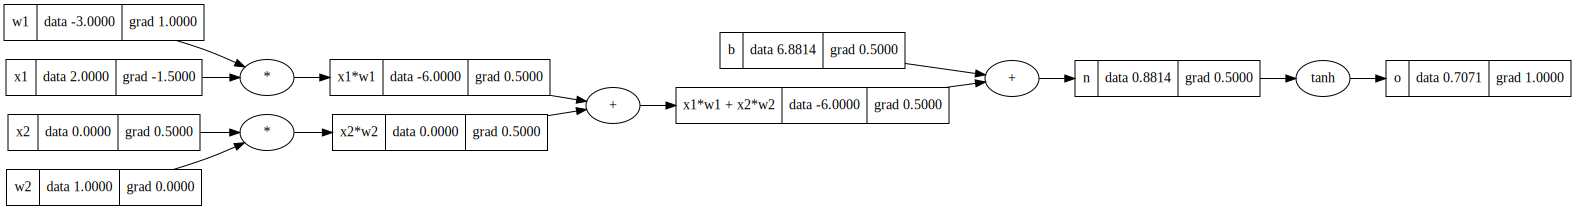

In [136]:
draw_dot(o)

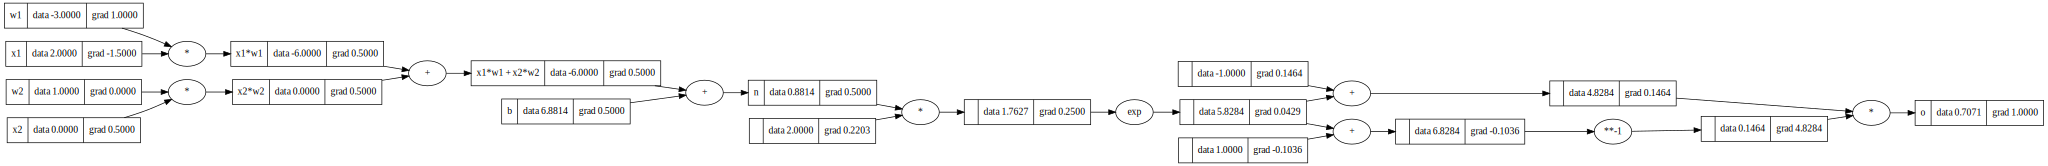

In [138]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
# -------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -------------
o.label="o"
o.backward()
draw_dot(o)

In [109]:
o.backward()

In [104]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

In [101]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [90]:
o.grad = 1.0

In [92]:
o._backward()

In [94]:
n._backward()

In [96]:
b._backward()

In [97]:
x1w1x2w2._backward()

In [99]:
x2w2._backward()
x1w1._backward()

In [76]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [74]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [72]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [69]:
o.grad = 1.0
n.grad = 0.5

In [70]:
1 - (o.data ** 2)

0.4999999999999999

In [ ]:
# o = tanh(n)
# do / dn = 1 - o ** 2

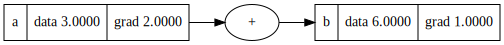

In [114]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)

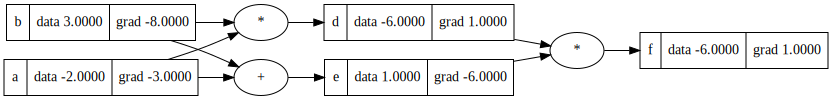

In [115]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a*b ; d.label="d"
e = a+b ; e.label="e"
f = d*e ; f.label="f"

f.backward()

draw_dot(f)

In [139]:
# Literally same thing but just using PyTorch
import torch

x1 = torch.Tensor([2.0]).double()                       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()         ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-----------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
-----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [140]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [142]:
import random

In [209]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [210]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7125292991199775)

In [211]:
n.parameters()

[Value(data=0.3061741608785409),
 Value(data=0.1295347312412849),
 Value(data=0.5679738893606852),
 Value(data=0.32311130953210543),
 Value(data=0.8773523146843458),
 Value(data=-0.23799275974363998),
 Value(data=0.49673248770657774),
 Value(data=-0.6089676311421919),
 Value(data=0.818318999952629),
 Value(data=-0.5362134153301947),
 Value(data=-0.050824518129559904),
 Value(data=0.6954953078489103),
 Value(data=0.27396701132280477),
 Value(data=-0.7495115240098709),
 Value(data=-0.0014169077957231213),
 Value(data=0.8249304434325038),
 Value(data=-0.40254163160493417),
 Value(data=0.7846587426873834),
 Value(data=-0.03162669739926027),
 Value(data=-0.1400377842363998),
 Value(data=-0.35964080322987035),
 Value(data=0.6152589814641738),
 Value(data=-0.6790265561562363),
 Value(data=0.13591099939534357),
 Value(data=0.4939269948860705),
 Value(data=-0.46948199394007784),
 Value(data=-0.9952404707400155),
 Value(data=-0.40869908210163874),
 Value(data=0.07662179313010009),
 Value(data=-0

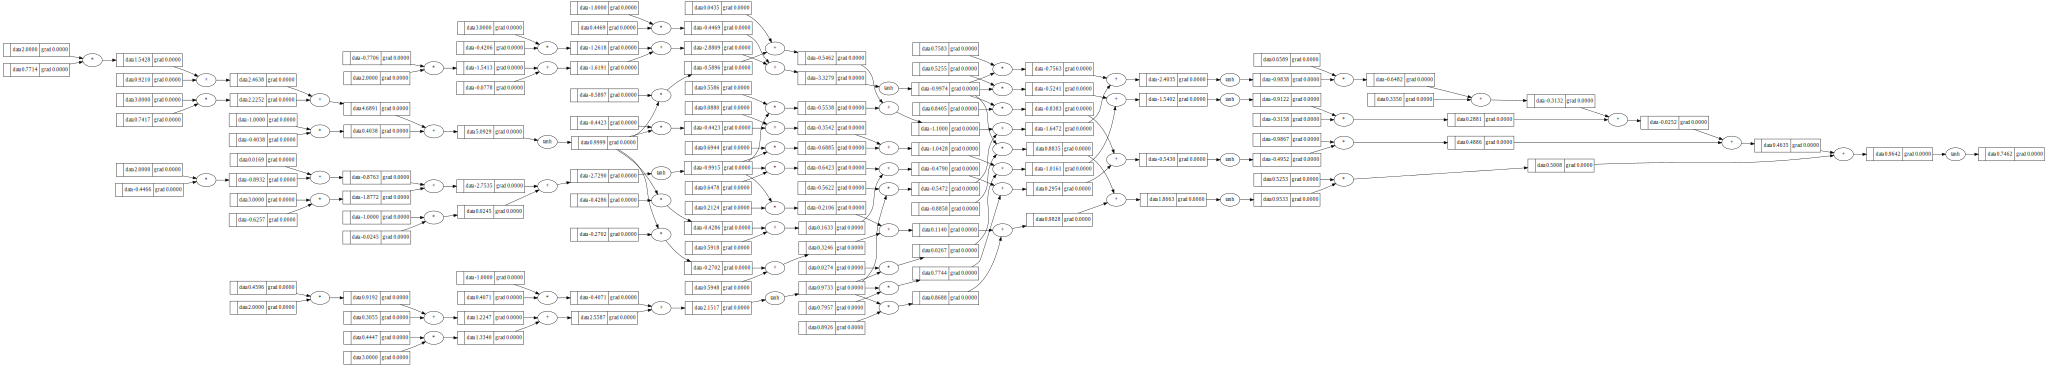

In [184]:
draw_dot(n(x))

In [224]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [214]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.782386638261153)

In [215]:
loss.backward()

In [216]:
n.layers[0].neurons[0].w[0].grad

-0.8943679827688914

In [217]:
n.layers[0].neurons[0].w[0].data

0.3061741608785409

In [219]:
for p in n.parameters():
  p.data -= 0.01 * p.grad

In [221]:
n.layers[0].neurons[0].w[0].data

0.3151178407062298

In [223]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.457331583385924)

In [226]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # .zero_grad()
  loss.backward()

  # update
  for p in n.parameters():
    p.data -= 0.05 * p.grad

  print(k, loss.data)


0 0.06960384394403954
1 0.06458673096988352
2 0.06020652311185825
3 0.05635202654600793
4 0.052936146506229825
5 0.04988975654713424
6 0.04715733537150479
7 0.04469380731368764
8 0.04246221824627759
9 0.040432001449185774
10 0.03857766672206159
11 0.036877797546785974
12 0.03531427544820182
13 0.03387167397898824
14 0.032536780780250775
15 0.03129821736207258
16 0.030146134170326463
17 0.02907196418305231
18 0.028068222395098222
19 0.02712834156537324


In [227]:
ypred

[Value(data=0.9344584980992111),
 Value(data=-0.9137782472183305),
 Value(data=-0.9276757402242155),
 Value(data=0.8991651652993687)]